In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

In [3]:
import altair as alt

alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

# Load model

### User Input:
1. model_path - path to .pickle file of pretrained model
2. train_data_path - path to train data
3. test_data_path - path to test data
4. categorical_features - which features are categorical

In [4]:
model_path = 'loan_model.pickle'
X_train_data_path = 'loan_model_X_train_data.csv'
y_train_data_path = 'loan_model_y_train_data.csv'
X_test_data_path = 'loan_model_X_test_data.csv'
categorical_features = [0, 1, 2, 3, 4, 9, 10, 11]

---

In [6]:
import pickle

pickle_in = open(model_path,"rb")
model = pickle.load(pickle_in)
model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [7]:
X_train = pd.read_csv(X_train_data_path)
y_train = pd.read_csv(y_train_data_path)
X_test = pd.read_csv(X_test_data_path)

In [8]:
def model_prediction(x):
    return model.predict_proba(x)

# Skater (analyze model)

## Feature importance

2019-05-09 15:02:00,269 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False


[12/12] features ████████████████████ Time elapsed: 0 seconds

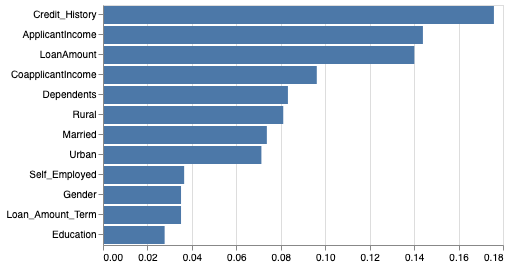

In [9]:
from src import feature_importance

feature_importance.analyze(model_prediction, X_train, render=True)

## Partial dependence 


2019-05-09 15:20:02,910 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[400/400] grid cells ████████████████████ Time elapsed: 12 seconds

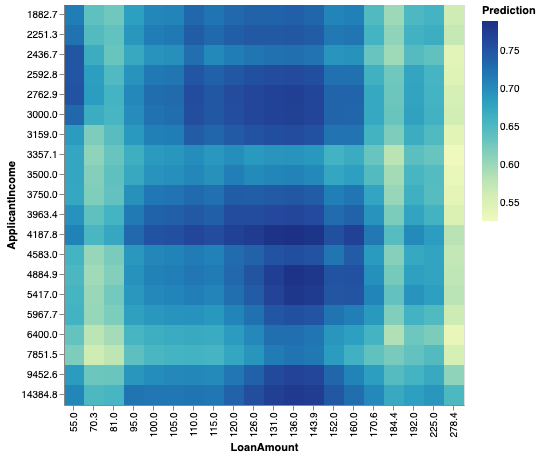

In [29]:
from src import partial_dependence

feature_1 = 'LoanAmount'
feature_2 = 'ApplicantIncome'

partial_dependence.analyze([feature_1, feature_2], model_prediction, X_train, render=True)

### TreeSurrogates (Experimental)

2019-05-09 15:19:26,088 - skater.core.global_interpretation.tree_surrogate - INFO - post pruning applied ...
2019-05-09 15:19:26,093 - skater.core.global_interpretation.tree_surrogate - INFO - Scorer used cross-entropy
2019-05-09 15:19:26,097 - skater.core.global_interpretation.tree_surrogate - INFO - original score using base model 9.992007221626413e-16
2019-05-09 15:19:26,211 - skater.core.global_interpretation.tree_surrogate - INFO - Summary: childrens of the following nodes are removed [5]
2019-05-09 15:19:26,213 - skater.core.global_interpretation.tree_surrogate - INFO - Done generating prediction using the surrogate, shape (384, 2)
2019-05-09 15:19:26,215 - skater.core.global_interpretation.tree_surrogate - INFO - Done scoring, surrogate score 0.008; oracle score 0.134
2019-05-09 15:19:26,216 - skater.core.global_interpretation.tree_surrogate - WARNING - impurity score: 0.126 of the surrogate model is higher than the impurity threshold: 0.01. The higher the impurity score, lower 

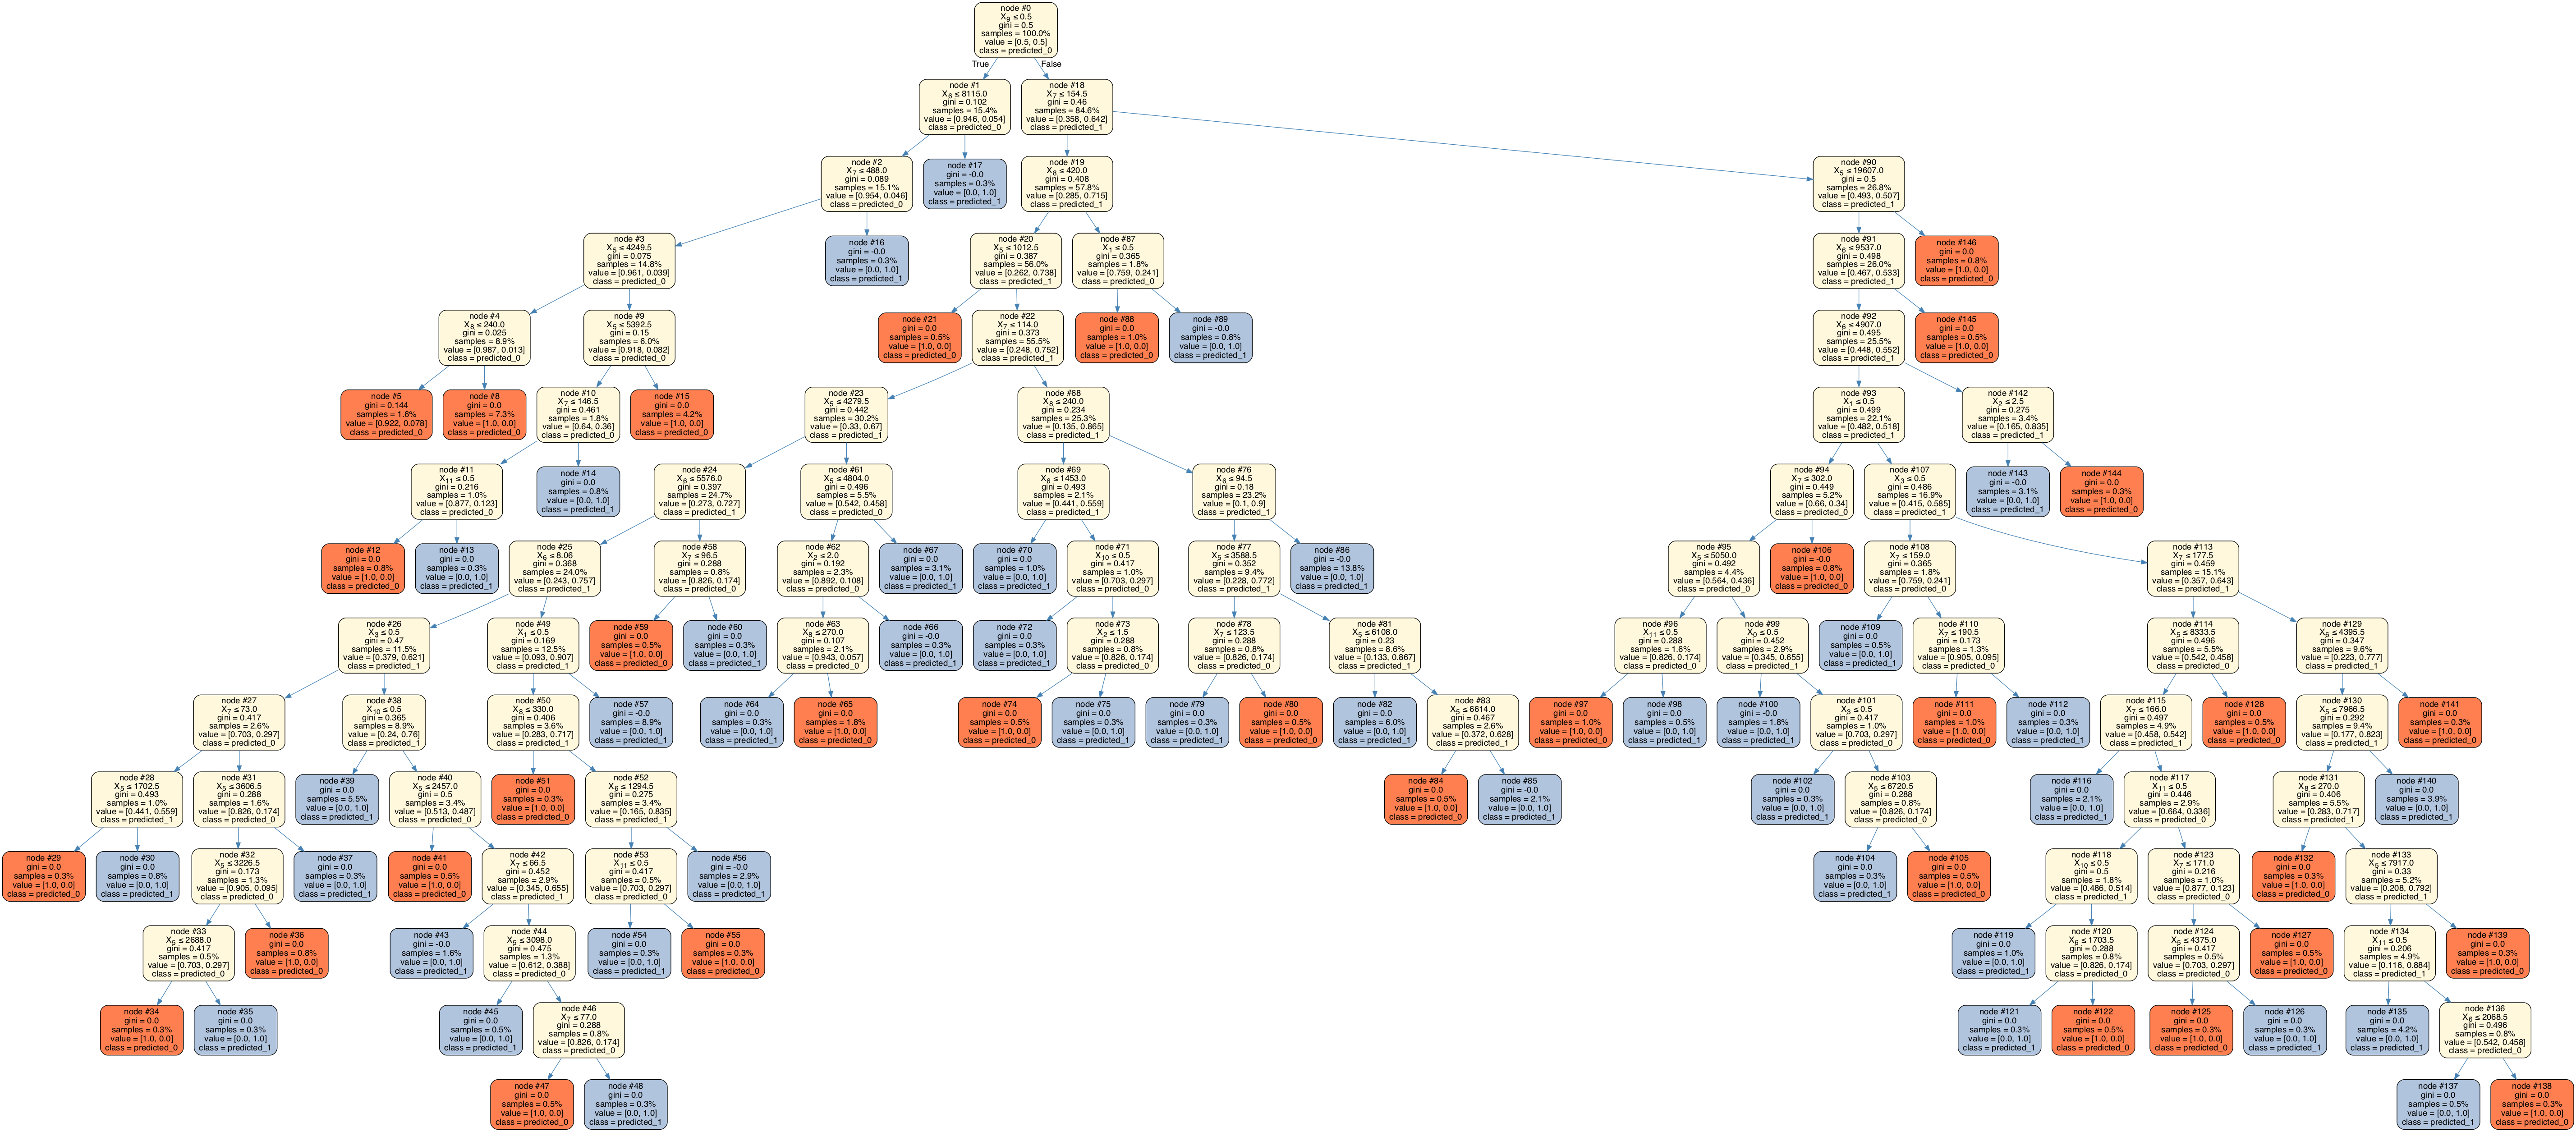

In [28]:
from src import tree_surrogate

tree_surrogate.analyze(model_prediction, X_train, y_train)

## Contrastive explanation
Based on https://arxiv.org/pdf/1806.07470.pdf and https://github.com/MarcelRobeer/ContrastiveExplanation

In [30]:
import src.contrastive_explanation as ce

dm = ce.domain_mappers.DomainMapperTabular(X_train.values, 
                                           feature_names = X_train.columns,
                                           categorical_features = categorical_features)

exp = ce.ContrastiveExplanation(dm)

### User Input:

- select test data indexes

In [31]:
indexes = [3, 6]

---

In [32]:
for i in indexes:
    sample = X_train.values[i]
    print('------')
    print(sample)
    print(exp.explain_instance_domain(model_prediction, sample))

------
[0.000e+00 1.000e+00 2.000e+00 1.000e+00 0.000e+00 2.708e+03 1.167e+03
 9.700e+01 3.600e+02 1.000e+00 0.000e+00 0.000e+00]
The model predicted '1' instead of '0' because 'CoapplicantIncome > -2220.654'
------
[0.00e+00 1.00e+00 1.00e+00 1.00e+00 0.00e+00 6.40e+03 7.25e+03 1.80e+02
 3.60e+02 0.00e+00 1.00e+00 0.00e+00]
The model predicted '0' instead of '1' because 'not Credit_History and Loan_Amount_Term <= 424.514 and Married and not Dependents'
